In [25]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 데이터 로드
file_path = '/content/drive/MyDrive/Halitosis/241121_Halitosis_data preprocessing.xlsx'
data = pd.read_excel(file_path)

# 입력 Feature와 타겟 변수 설정
input_features = [
    'Sex', 'Age', 'Elderly', 'Super_Elderly', 'Xerostomia_subjective',
    'UFR', 'SFR', 'pH', 'BufferCapacity', 'VAS', 'StickySaliva', 'Oralhygiene',
    'Calculus', 'O_Stomatitis', 'O_RAU', 'O_Candidiasis', 'O_Periodontitis',
    'O_LichenPlanus', 'O_Sialodochitis', 'O_Glossodynia', 'O_BMS',
    'S_Hypertension', 'S_DM', 'S_Hyperlipidemia', 'S_RenalDiseases',
    'S_LiverDiseases', 'S_Rheumatism', 'S_Osteoporosis', 'S_CVD', 'S_TD',
    'S_MentalDisorders', 'S_UrinaryDiseases', 'S_Asthma', 'S_CancerOp',
    'NumberofSystmicDiseases', 'M_Hypertension', 'M_DM', 'M_Osteoporosis',
    'M_Hyperlipidemia', 'M_CV', 'M_TD', 'M_GI', 'M_UrinaryDiseases',
    'M_Arthritis', 'M_Rheumatism', 'M_Anxiolytic', 'M_SleepingPills',
    'M_Aspirin'
]
target_feature = 'Halitosis_subjective'

# Feature와 타겟 분리
X = data[input_features]
y = data[target_feature]

# Feature 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [24]:
import torch
import torch.nn as nn

class FeatureTransformer(nn.Module):
    def __init__(self, input_dim, num_heads=2, num_layers=2):
        super(FeatureTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, input_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(input_dim, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)  # Add sequence length dimension
        x = self.transformer_encoder(x)
        x = x.squeeze(1)  # Remove sequence length dimension
        output = torch.sigmoid(self.fc(x))
        return output


In [22]:
class FeatureTransformerWithAttention(nn.Module):
    def __init__(self, input_dim, num_heads=2, num_layers=2):
        super(FeatureTransformerWithAttention, self).__init__()
        self.embedding = nn.Linear(input_dim, input_dim)
        self.attention_layers = nn.ModuleList(
            [nn.MultiheadAttention(embed_dim=input_dim, num_heads=num_heads) for _ in range(num_layers)]
        )
        self.fc = nn.Linear(input_dim, 1)
        self.attention_weights = None

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)  # Add sequence length dimension
        for attn_layer in self.attention_layers:
            x, attn_weights = attn_layer(x, x, x)
        self.attention_weights = attn_weights.mean(dim=1).detach().numpy()
        x = x.squeeze(1)  # Remove sequence length dimension
        output = torch.sigmoid(self.fc(x))
        return output


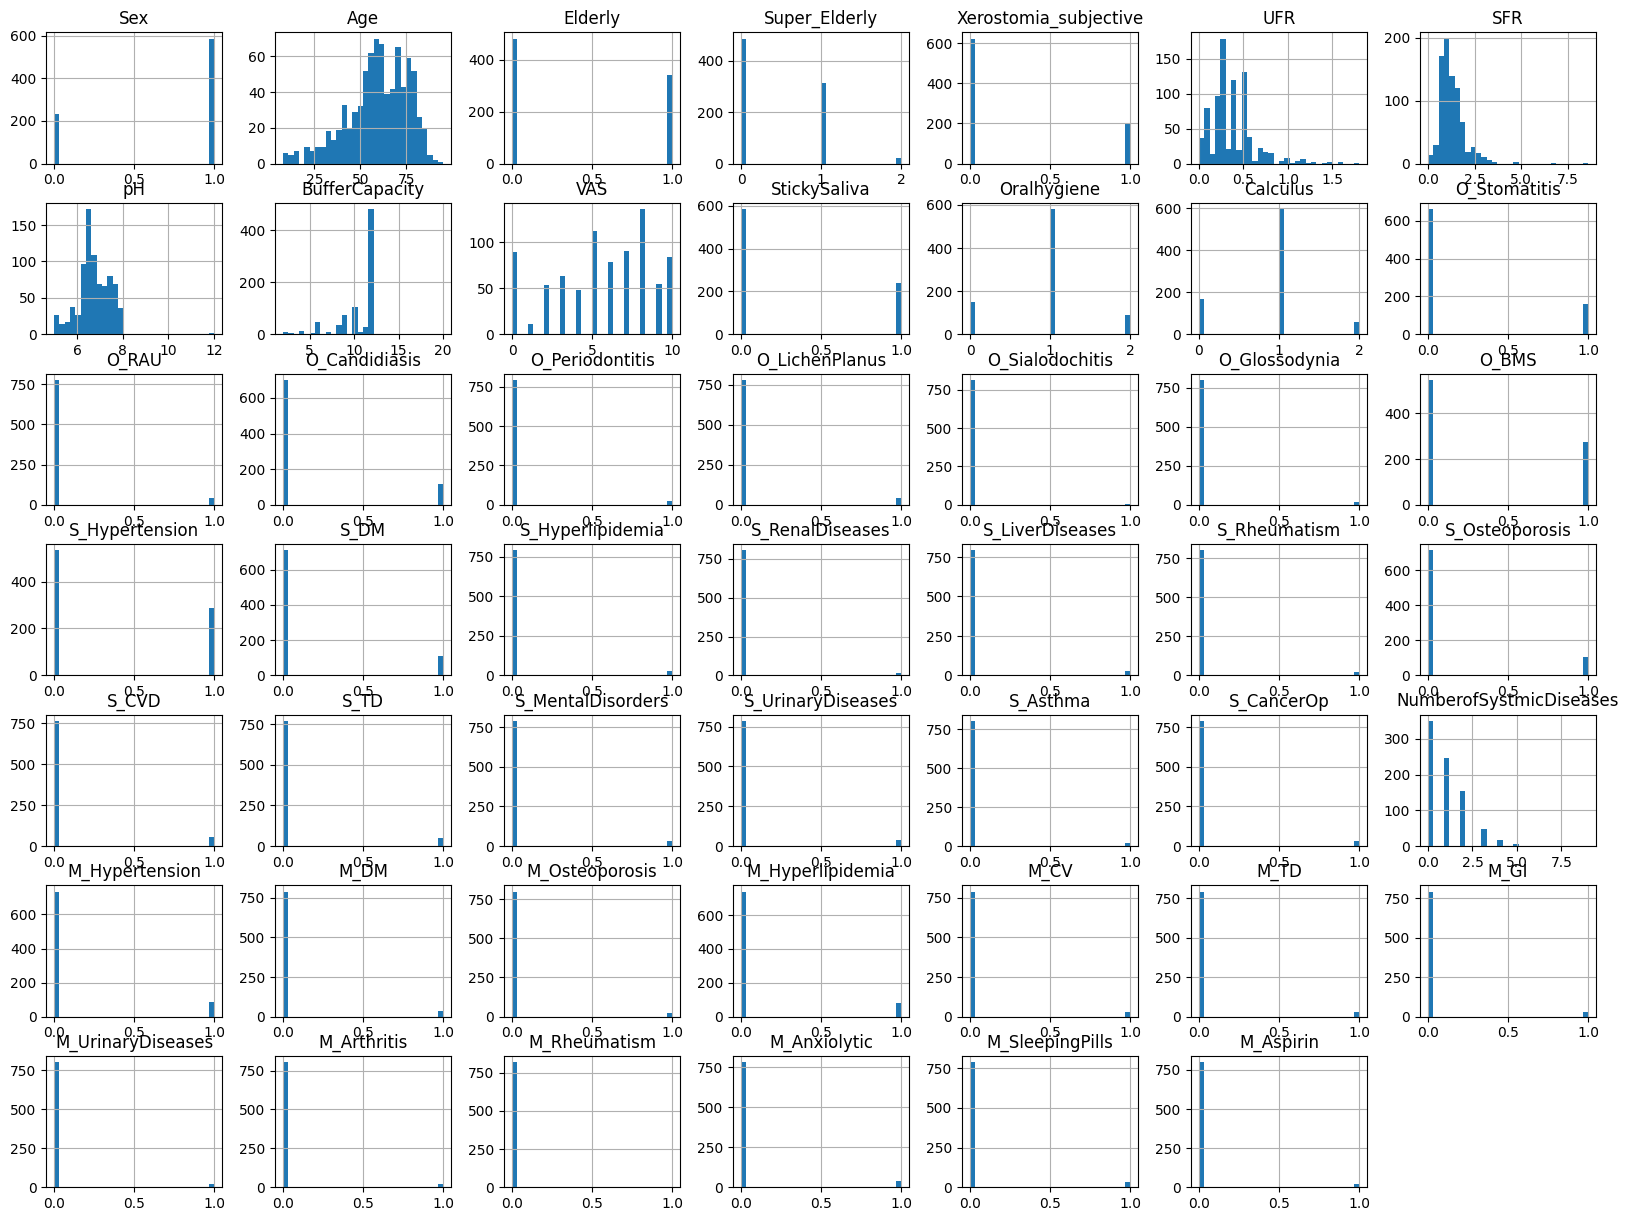

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature 분포 확인
data[input_features].hist(figsize=(20, 15), bins=30)
plt.show()


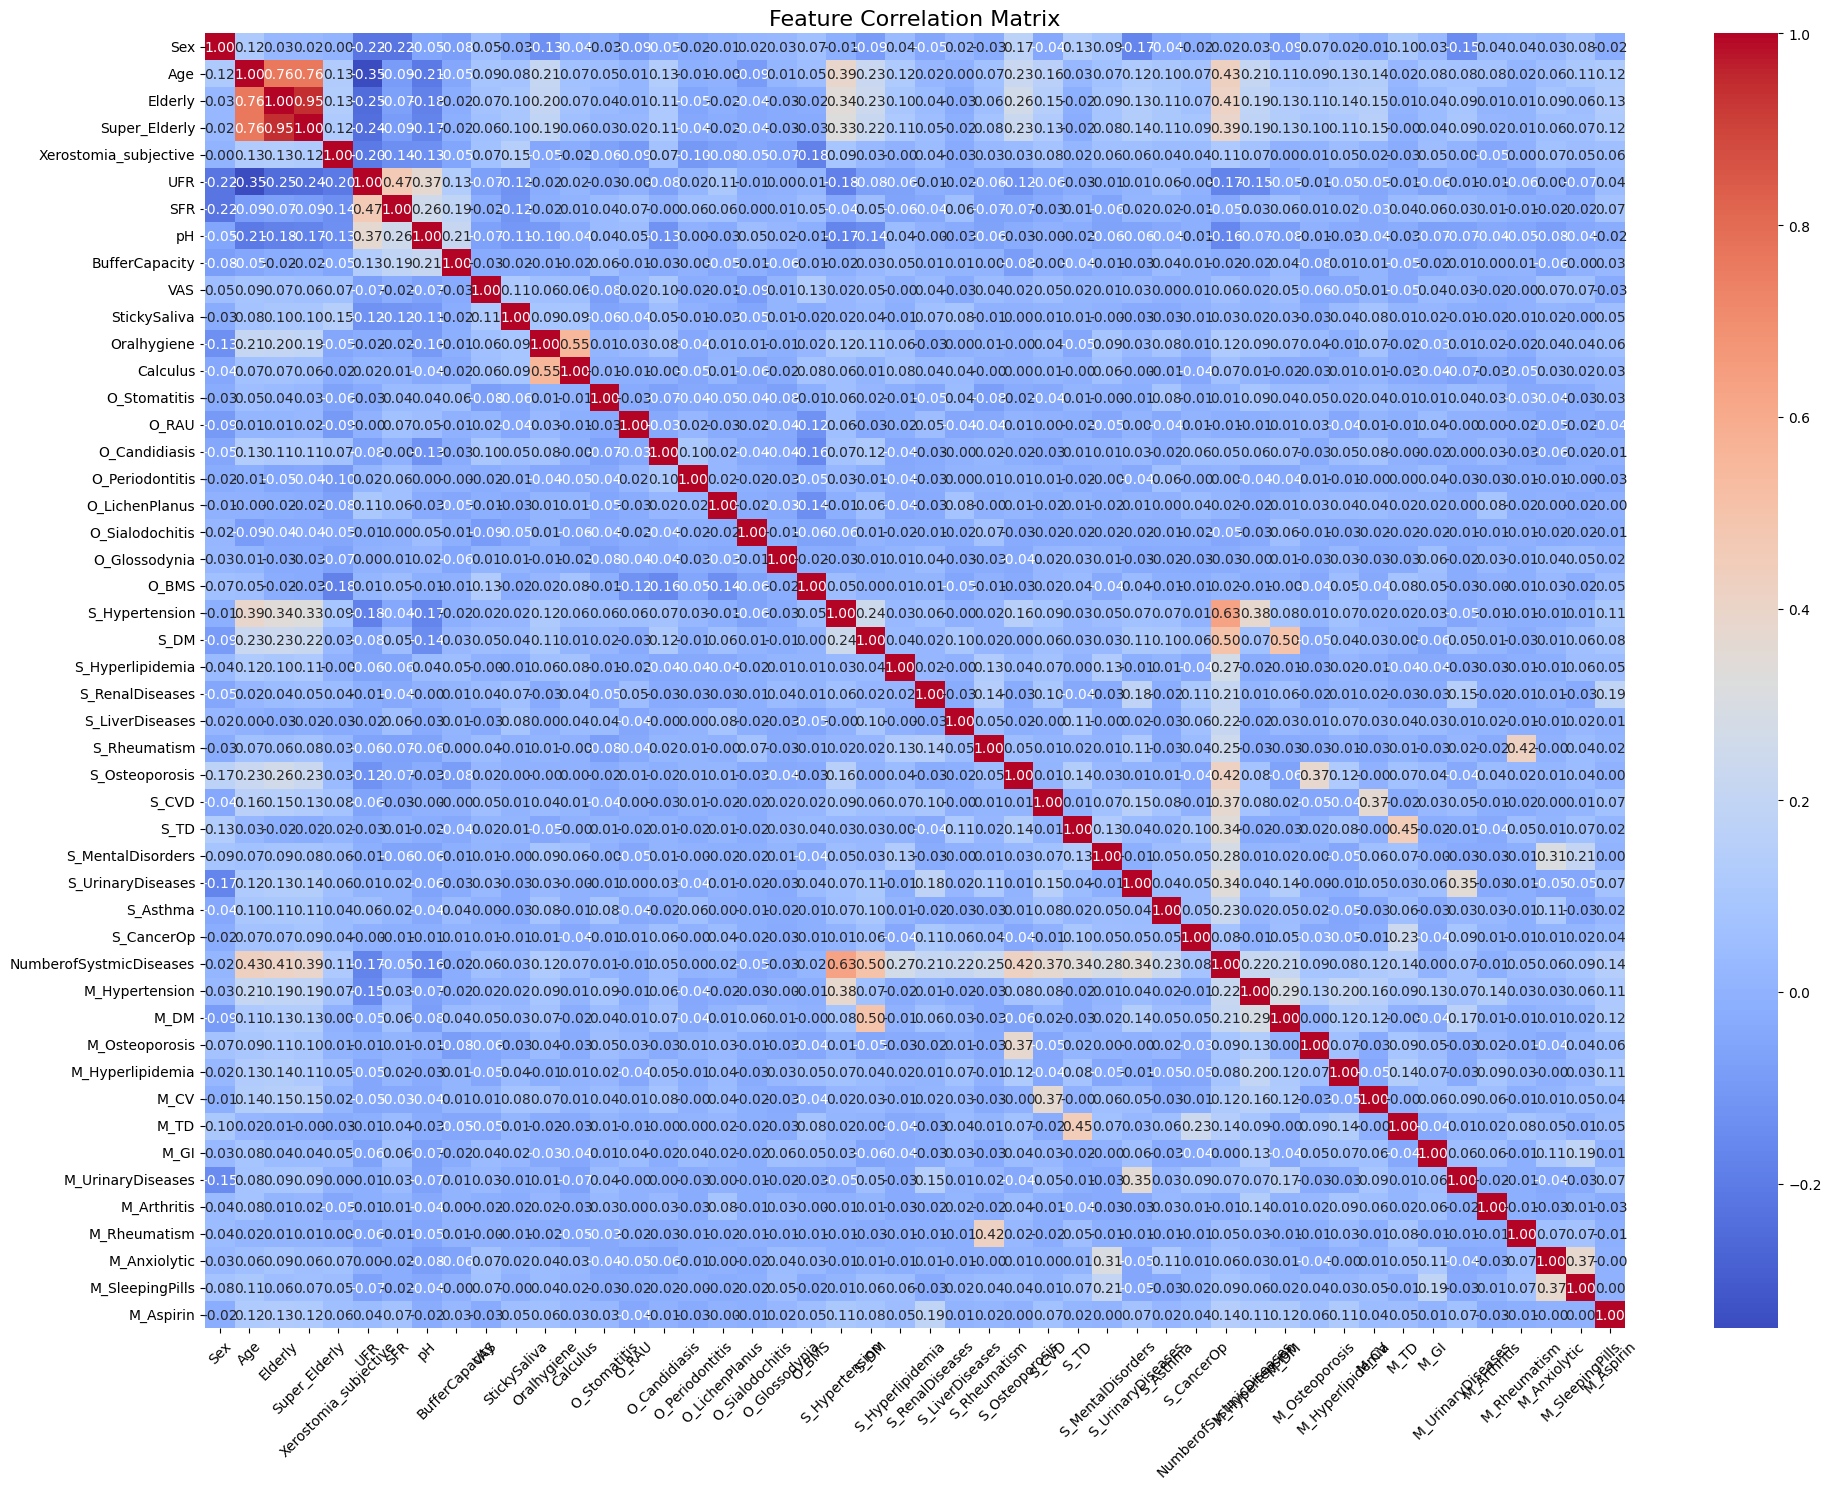

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Feature 간 상관관계 행렬 계산
correlation_matrix = data[input_features].corr()

# Heatmap 시각화
plt.figure(figsize=(20, 15))  # 크기를 조정
sns.heatmap(
    correlation_matrix,
    annot=True,  # 수치 표시
    fmt=".2f",   # 소수점 두 자리까지 표시
    cmap="coolwarm",
    annot_kws={"size": 10}  # 수치 텍스트 크기 조정
)
plt.title("Feature Correlation Matrix", fontsize=16)  # 제목 크기 조정
plt.xticks(fontsize=10, rotation=45)  # x축 텍스트 크기 및 각도
plt.yticks(fontsize=10)  # y축 텍스트 크기
plt.tight_layout()  # 여백 자동 조정
plt.show()




In [28]:
import torch
import torch.nn as nn

class FeatureAttentionModel(nn.Module):
    def __init__(self, input_dim, num_heads=2, num_layers=2):
        super(FeatureAttentionModel, self).__init__()
        self.embedding = nn.Linear(input_dim, input_dim)  # Feature Dimension 유지
        encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(input_dim, 1)
        self.attention_weights = None

    def forward(self, x):
        x = self.embedding(x)  # (Batch, Seq_len, Feature_dim)
        x = x.unsqueeze(1)  # (Batch, Seq_len=1, Feature_dim)
        x = self.transformer_encoder(x)
        self.attention_weights = x.mean(dim=1)  # Attention 가중치 저장
        x = x.squeeze(1)  # (Batch, Feature_dim)
        output = torch.sigmoid(self.fc(x))
        return output


In [29]:
# 데이터 준비
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)  # Scaled 입력 데이터
y_tensor = torch.tensor(y.values, dtype=torch.float32)

# 데이터 로더 준비
from torch.utils.data import DataLoader, TensorDataset

batch_size = 32
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 모델 초기화
input_dim = X_scaled.shape[1]
model = FeatureAttentionModel(input_dim=input_dim, num_heads=4, num_layers=2)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 학습 루프
for epoch in range(5):  # Epoch 수 조정 가능
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/5], Loss: {loss.item():.4f}")


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Loss: 0.5044
Epoch [2/5], Loss: 0.2390
Epoch [3/5], Loss: 0.4293
Epoch [4/5], Loss: 0.6095
Epoch [5/5], Loss: 0.2780


In [42]:
# Attention 가중치 추출
model.eval()
with torch.no_grad():
    sample_X = torch.tensor(X_scaled[:1], dtype=torch.float32)  # 샘플 데이터
    model(sample_X)
    attention_weights = model.attention_weights.squeeze(0).detach().numpy()

# Attention 가중치 확인
print("Attention Weights Shape:", attention_weights.shape)

# 모델 출력과 타겟 데이터 비교
outputs = model(batch_X).squeeze()  # (Batch,)
loss = criterion(outputs, batch_y)  # 손실 계산


# Heatmap 크기 및 가시성 조정
plt.figure(figsize=(20, 15))  # 시각화 크기 조정
sns.heatmap(
    attention_weights,
    annot=True,
    cmap="viridis",
    fmt=".2f",
    xticklabels=input_features,
    yticklabels=input_features,
    annot_kws={"size": 10}  # 숫자 크기 조정
)
plt.title("Feature Attention Map", fontsize=16)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()




Attention Weights Shape: (48,)


IndexError: Inconsistent shape between the condition and the input (got (48, 1) and (48,))

<Figure size 2000x1500 with 0 Axes>

In [31]:
# y 데이터의 차원 확인 및 변환
print("Before Reshape:", y_tensor.shape)
y_tensor = y_tensor.view(-1)  # (Batch,)
print("After Reshape:", y_tensor.shape)


Before Reshape: torch.Size([821])
After Reshape: torch.Size([821])


In [37]:
# 데이터 로드 및 텐서화
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1)  # 차원 맞추기

# 데이터 확인
print("X Shape:", X_tensor.shape)
print("y Shape:", y_tensor.shape)

# 데이터로더 준비
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)



X Shape: torch.Size([821, 48])
y Shape: torch.Size([821])


In [41]:
# 모델 출력 확인
outputs = model(batch_X).squeeze()  # (Batch,) 형태로 변환

# 손실 계산
loss = criterion(outputs, batch_y)


In [43]:
# 데이터 준비
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1)  # (Batch,) 형태로 변환

# 데이터로더 준비
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# 학습 루프
for epoch in range(5):
    for batch_X, batch_y in dataloader:
        batch_y = batch_y.view(-1)  # (Batch,) 형태로 맞춤
        optimizer.zero_grad()
        outputs = model(batch_X).squeeze()  # (Batch,)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/5], Loss: {loss.item():.4f}")


Epoch [1/5], Loss: 0.4282
Epoch [2/5], Loss: 0.5177
Epoch [3/5], Loss: 0.2429
Epoch [4/5], Loss: 0.0971
Epoch [5/5], Loss: 0.0855
